# <center> BFO online learning

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

### Defining Benchmark Functions

In [9]:

def ackley_function(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = len(x)
    sum1 = np.sum(x**2)
    sum2 = np.sum(np.cos(c * x))
    term1 = -a * np.exp(-b * np.sqrt(sum1 / d))
    term2 = -np.exp(sum2 / d)
    return term1 + term2 + a + np.exp(1)

def rastrigin_function(x):
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def sphere_function(x):
    return np.sum(x**2)


### Imlemeting BFO algorithm

In [5]:
class BFO:
    def __init__(self, p, S, Nc, Ns, Ned, Nr, ped, LB, UB, C, OF):
        self.p = p            # Number of dimensions
        self.S = S            # Number of bacteria
        self.Nc = Nc          # Number of chemotactic steps
        self.Ns = Ns          # Swimming length
        self.Ned = Ned        # Number of elimination-dispersal events
        self.Nr = Nr          # Number of reproduction steps
        self.ped = ped        # Elimination-dispersal probability
        self.LB = np.array([LB] * p) # Lower bounds
        self.UB = np.array([UB] * p) # Upper bounds
        self.C = C            # Step size
        self.OF = OF          # Objective function

    def run(self):
        # Initialize population of bacteria
        population = self.LB[:, np.newaxis] + (self.UB[:, np.newaxis] - self.LB[:, np.newaxis]) * np.random.rand(self.p, self.S)
        fitness = np.apply_along_axis(self.OF, 0, population)
        best_solution = population[:, np.argmin(fitness)]
        best_fitness = np.min(fitness)
        best_fitness_history = [best_fitness]

        # Elimination-dispersal loop
        for l in range(self.Ned):
            # Reproduction loop
            for k in range(self.Nr):
                # Chemotactic loop
                for j in range(self.Nc):
                    for i in range(self.S):
                        # Perform a chemotactic step
                        delta = (2 * np.random.rand(self.p) - 1)
                        delta /= np.linalg.norm(delta)
                        new_position = population[:, i] + self.C * delta
                        
                        # Ensure the new position is within bounds
                        new_position = np.clip(new_position, self.LB, self.UB)
                        new_fitness = self.OF(new_position)

                        # Swim
                        for m in range(self.Ns):
                            if new_fitness < fitness[i]:
                                population[:, i] = new_position
                                fitness[i] = new_fitness

                                new_position = population[:, i] + self.C * delta
                                new_position = np.clip(new_position, self.LB, self.UB)
                                new_fitness = self.OF(new_position)
                            else:
                                break

                    best_fitness_history.append(np.min(fitness))
                    
                # Reproduction
                health = np.sum(fitness.reshape(self.S, 1), axis=1)
                sorted_indices = np.argsort(health)
                population = population[:, sorted_indices]
                fitness = fitness[sorted_indices]

                # Split the best bacteria
                for i in range(self.S // 2, self.S):
                    population[:, i] = population[:, i - self.S // 2]
                    fitness[i] = fitness[i - self.S // 2]

            # Elimination-dispersal
            for i in range(self.S):
                if np.random.rand() < self.ped:
                    population[:, i] = self.LB + (self.UB - self.LB) * np.random.rand(self.p)
                    fitness[i] = self.OF(population[:, i])
                    
            # Update best solution
            current_best_fitness = np.min(fitness)
            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                best_solution = population[:, np.argmin(fitness)]
                best_fitness_history.append(best_fitness)

        return best_fitness, best_solution, best_fitness_history


### Implementing Adaptive BFO algorithm

In [6]:
class ABFO0:
    def __init__(self, p, S, Nc, Ns, Ned, Nr, ped, LB, UB, C_initial, alpha, beta, epsilon, OF):
        self.p = p            # Number of dimensions
        self.S = S            # Number of bacteria
        self.Nc = Nc          # Number of chemotactic steps
        self.Ns = Ns          # Swimming length
        self.Ned = Ned        # Number of elimination-dispersal events
        self.Nr = Nr          # Number of reproduction steps
        self.ped = ped        # Elimination-dispersal probability
        self.LB = np.array([LB] * p) # Lower bounds
        self.UB = np.array([UB] * p) # Upper bounds
        self.C_initial = C_initial  # Initial step size
        self.alpha = alpha    # Parameter adaptation factor
        self.beta = beta      # Parameter adaptation factor
        self.epsilon = epsilon # Convergence threshold
        self.OF = OF          # Objective function

    def adapt_parameters(self, fitness, best_fitness):
        if best_fitness < self.epsilon:
            return self.C_initial / self.alpha, self.epsilon / self.beta
        return self.C_initial, self.epsilon

    def run(self):
        # Initialize population of bacteria
        population = self.LB[:, np.newaxis] + (self.UB[:, np.newaxis] - self.LB[:, np.newaxis]) * np.random.rand(self.p, self.S)
        fitness = np.apply_along_axis(self.OF, 0, population)
        best_solution = population[:, np.argmin(fitness)]
        best_fitness = np.min(fitness)
        best_fitness_history = [best_fitness]

        C = self.C_initial  # Initialize C

        # Elimination-dispersal loop
        for l in range(self.Ned):
            # Reproduction loop
            for k in range(self.Nr):
                # Chemotactic loop
                for j in range(self.Nc):
                    for i in range(self.S):
                        # Perform a chemotactic step
                        delta = (2 * np.random.rand(self.p) - 1)
                        delta /= np.linalg.norm(delta)
                        new_position = population[:, i] + C * delta
                        
                        # Ensure the new position is within bounds
                        new_position = np.clip(new_position, self.LB, self.UB)
                        new_fitness = self.OF(new_position)

                        # Swim
                        for m in range(self.Ns):
                            if new_fitness < fitness[i]:
                                population[:, i] = new_position
                                fitness[i] = new_fitness

                                new_position = population[:, i] + C * delta
                                new_position = np.clip(new_position, self.LB, self.UB)
                                new_fitness = self.OF(new_position)
                            else:
                                break

                    best_fitness_history.append(np.min(fitness))
                    
                # Reproduction
                health = np.sum(fitness.reshape(self.S, 1), axis=1)
                sorted_indices = np.argsort(health)
                population = population[:, sorted_indices]
                fitness = fitness[sorted_indices]

                # Split the best bacteria
                for i in range(self.S // 2, self.S):
                    population[:, i] = population[:, i - self.S // 2]
                    fitness[i] = fitness[i - self.S // 2]

            # Elimination-dispersal
            for i in range(self.S):
                if np.random.rand() < self.ped:
                    population[:, i] = self.LB + (self.UB - self.LB) * np.random.rand(self.p)
                    fitness[i] = self.OF(population[:, i])
                    
            # Update best solution and adapt parameters
            current_best_fitness = np.min(fitness)
            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                best_solution = population[:, np.argmin(fitness)]

            C, self.epsilon = self.adapt_parameters(fitness, best_fitness)
            best_fitness_history.append(best_fitness)

        return best_fitness, best_solution, best_fitness_history


### Implementing self adaptive BFO algorithm

In [7]:
class ABFO1:
    def __init__(self, p, S, Nc, Ns, Ned, Nr, ped, LB, UB, C_initial, alpha, beta, epsilon, OF):
        self.p = p            # Number of dimensions
        self.S = S            # Number of bacteria
        self.Nc = Nc          # Number of chemotactic steps
        self.Ns = Ns          # Swimming length
        self.Ned = Ned        # Number of elimination-dispersal events
        self.Nr = Nr          # Number of reproduction steps
        self.ped = ped        # Elimination-dispersal probability
        self.LB = np.array([LB] * p) # Lower bounds
        self.UB = np.array([UB] * p) # Upper bounds
        self.C_initial = C_initial  # Initial step size
        self.alpha = alpha    # Parameter adaptation factor
        self.beta = beta      # Parameter adaptation factor
        self.epsilon = epsilon # Convergence threshold
        self.OF = OF          # Objective function

    def adapt_parameters(self, C, fitness, best_fitness):
        if best_fitness < self.epsilon:
            return C / self.alpha, self.epsilon / self.beta
        return C, self.epsilon

    def run(self):
        # Initialize population of bacteria
        population = self.LB[:, np.newaxis] + (self.UB[:, np.newaxis] - self.LB[:, np.newaxis]) * np.random.rand(self.p, self.S)
        fitness = np.apply_along_axis(self.OF, 0, population)
        best_solution = population[:, np.argmin(fitness)]
        best_fitness = np.min(fitness)
        best_fitness_history = [best_fitness]

        C = self.C_initial  # Initialize C

        # Elimination-dispersal loop
        for l in range(self.Ned):
            # Reproduction loop
            for k in range(self.Nr):
                # Chemotactic loop
                for j in range(self.Nc):
                    for i in range(self.S):
                        # Perform a chemotactic step
                        delta = (2 * np.random.rand(self.p) - 1)
                        delta /= np.linalg.norm(delta)
                        new_position = population[:, i] + C * delta
                        
                        # Ensure the new position is within bounds
                        new_position = np.clip(new_position, self.LB, self.UB)
                        new_fitness = self.OF(new_position)

                        # Swim
                        for m in range(self.Ns):
                            if new_fitness < fitness[i]:
                                population[:, i] = new_position
                                fitness[i] = new_fitness

                                new_position = population[:, i] + C * delta
                                new_position = np.clip(new_position, self.LB, self.UB)
                                new_fitness = self.OF(new_position)
                            else:
                                break

                    best_fitness_history.append(np.min(fitness))
                    
                # Reproduction
                health = np.sum(fitness.reshape(self.S, 1), axis=1)
                sorted_indices = np.argsort(health)
                population = population[:, sorted_indices]
                fitness = fitness[sorted_indices]

                # Split the best bacteria
                for i in range(self.S // 2, self.S):
                    population[:, i] = population[:, i - self.S // 2]
                    fitness[i] = fitness[i - self.S // 2]

            # Elimination-dispersal
            for i in range(self.S):
                if np.random.rand() < self.ped:
                    population[:, i] = self.LB + (self.UB - self.LB) * np.random.rand(self.p)
                    fitness[i] = self.OF(population[:, i])
                    
            # Update best solution and adapt parameters
            current_best_fitness = np.min(fitness)
            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                best_solution = population[:, np.argmin(fitness)]

            C, self.epsilon = self.adapt_parameters(C, fitness, best_fitness)
            best_fitness_history.append(best_fitness)

        return best_fitness, best_solution, best_fitness_history


## Comparison 

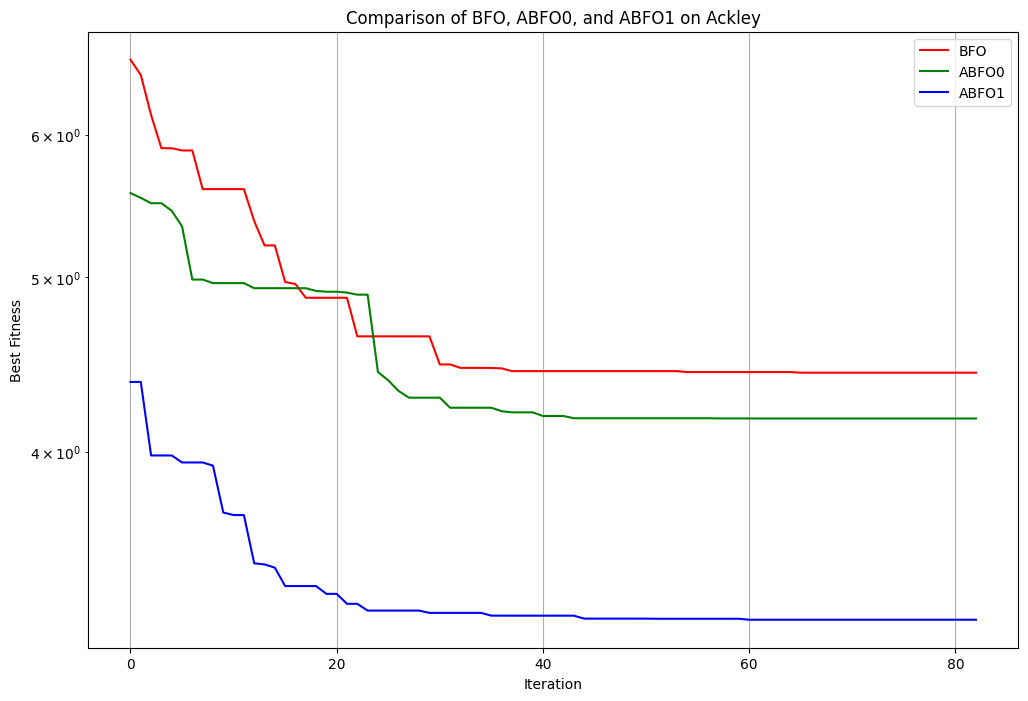

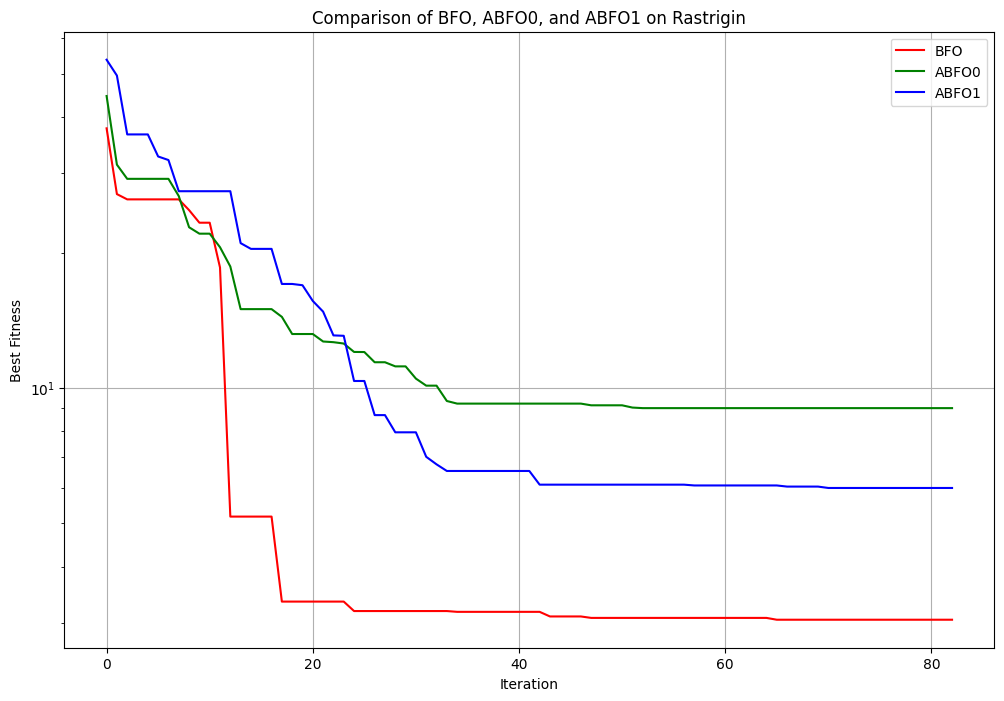

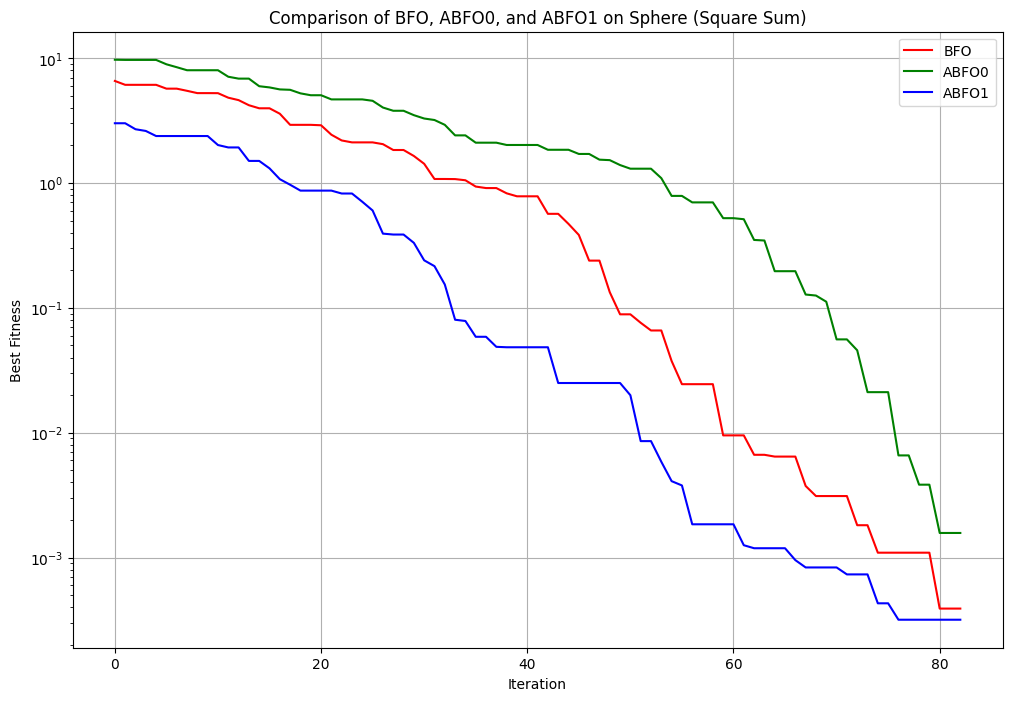

In [13]:
def compare_algorithms(dimension, population_size, Nc, Ns, Ned, Nr, ped, lower_bound, upper_bound, C_initial, alpha, beta, epsilon, functions, function_names):
    algorithms = [BFO, ABFO0, ABFO1]
    algorithm_names = ['BFO', 'ABFO0', 'ABFO1']
    colors = ['r', 'g', 'b']

    for f, fname in zip(functions, function_names):
        plt.figure(figsize=(12, 8))
        for alg, alg_name, color in zip(algorithms, algorithm_names, colors):
            if alg_name == 'BFO':
                algorithm = alg(dimension, population_size, Nc, Ns, Ned, Nr, ped, lower_bound, upper_bound, C_initial, f)
            else:
                algorithm = alg(dimension, population_size, Nc, Ns, Ned, Nr, ped, lower_bound, upper_bound, C_initial, alpha, beta, epsilon, f)
            best_fitness, best_solution, history = algorithm.run()
            plt.plot(history, label=f'{alg_name}', color=color)
        
        plt.title(f'Comparison of BFO, ABFO0, and ABFO1 on {fname}')
        plt.xlabel('Iteration')
        plt.ylabel('Best Fitness')
        plt.yscale('log')
        plt.legend()
        plt.grid(True)
        plt.show()

# Parameters
population_size = 50
dimension = 5
lower_bound = -5.12
upper_bound = 5.12
C_initial = 0.05
alpha = 0.95
beta = 0.9
epsilon = 1e-6
Nc = 10
Ns = 4
Ned = 2
Nr = 4
ped = 0.25

# Define the functions and their names
functions = [ackley_function, rastrigin_function, sphere_function]
function_names = ['Ackley', 'Rastrigin', 'Sphere (Square Sum)']

# Compare the algorithms
compare_algorithms(dimension, population_size, Nc, Ns, Ned, Nr, ped, lower_bound, upper_bound, C_initial, alpha, beta, epsilon, functions, function_names)

## Comparison with SGD

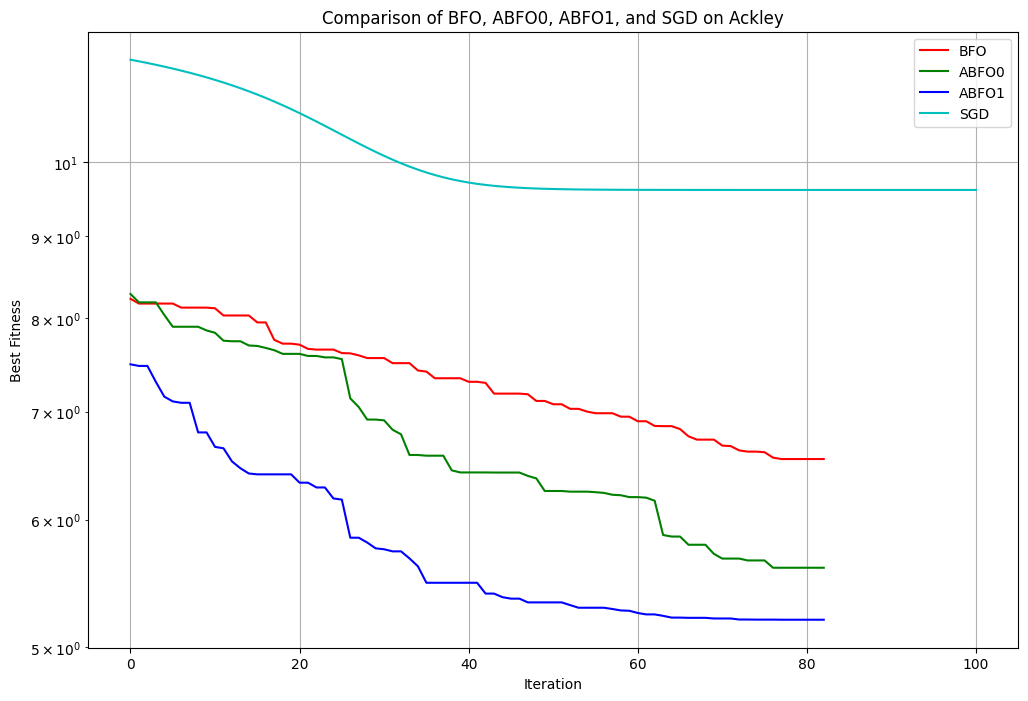

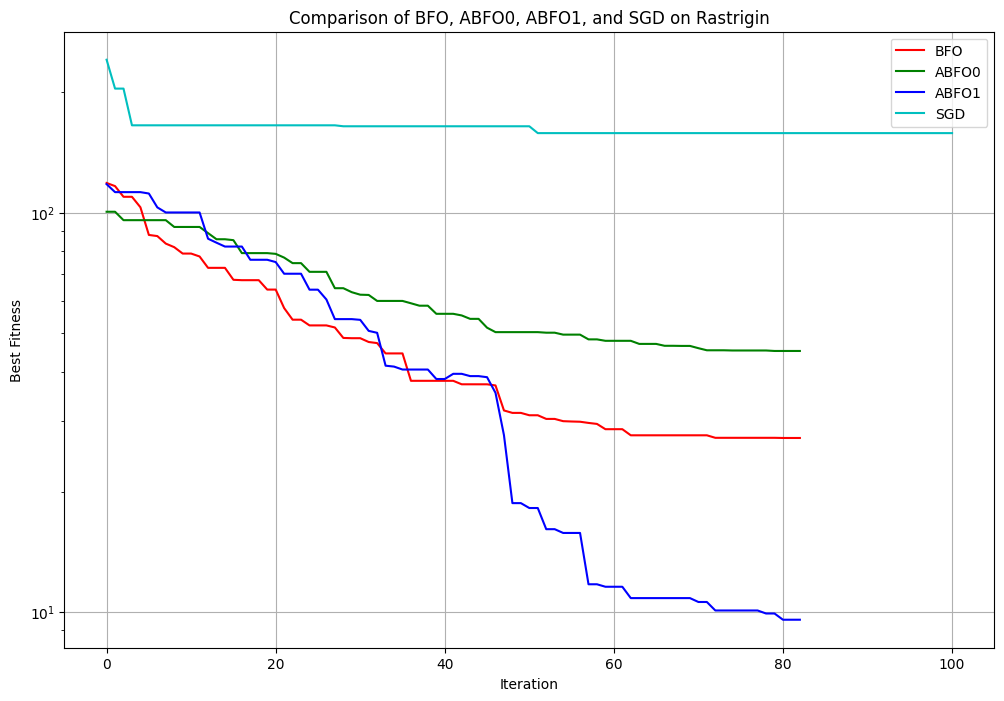

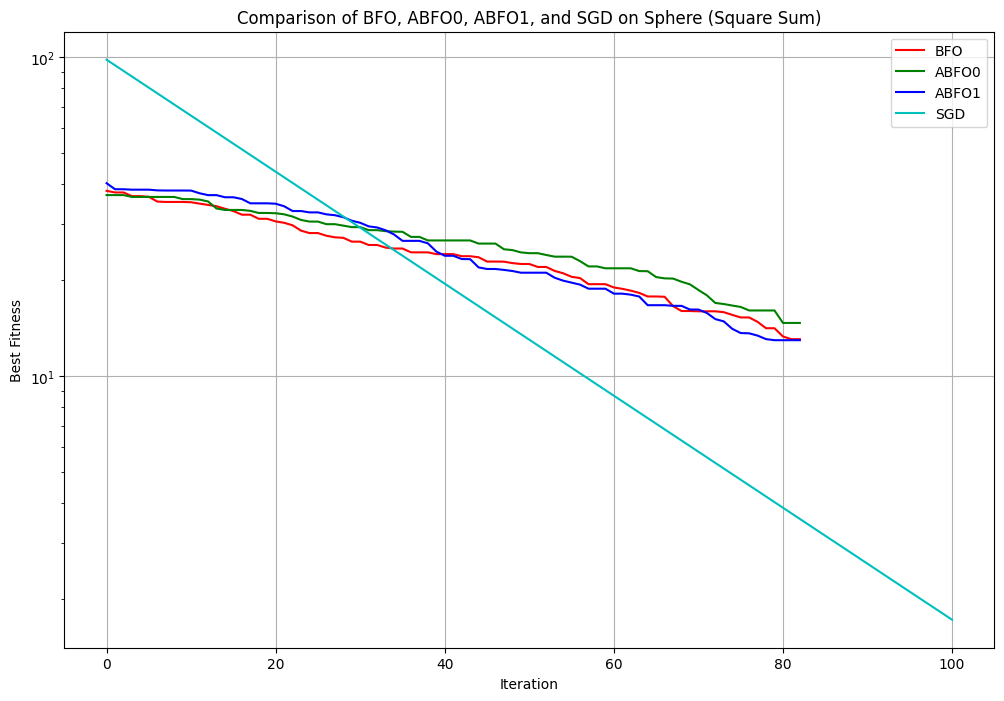

In [18]:
# Objective functions
def ackley_function(x):
    return -20.0 * np.exp(-0.2 * np.sqrt(np.mean(x**2))) - np.exp(np.mean(np.cos(2 * np.pi * x))) + 20 + np.e

def rastrigin_function(x):
    return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

def sphere_function(x):
    return np.sum(x**2)

# Implement SGD
class SGD:
    def __init__(self, p, lower_bound, upper_bound, learning_rate, n_iterations, OF):
        self.p = p
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.OF = OF

    def run(self):
        # Initialize solution
        solution = np.random.uniform(self.lower_bound, self.upper_bound, self.p)
        best_solution = solution
        best_fitness = self.OF(solution)
        best_fitness_history = [best_fitness]

        for _ in range(self.n_iterations):
            gradient = self.compute_gradient(solution)
            solution = solution - self.learning_rate * gradient
            solution = np.clip(solution, self.lower_bound, self.upper_bound)

            fitness = self.OF(solution)
            if fitness < best_fitness:
                best_fitness = fitness
                best_solution = solution

            best_fitness_history.append(best_fitness)

        return best_fitness, best_solution, best_fitness_history

    def compute_gradient(self, solution):
        grad = np.zeros_like(solution)
        h = 1e-5
        for i in range(len(solution)):
            x_plus_h = np.copy(solution)
            x_minus_h = np.copy(solution)
            x_plus_h[i] += h
            x_minus_h[i] -= h
            grad[i] = (self.OF(x_plus_h) - self.OF(x_minus_h)) / (2 * h)
        return grad

# Classes for BFO, ABFO0, and ABFO1 (same as provided)

# Define a function to run and plot comparisons
def compare_algorithms(dimension, population_size, Nc, Ns, Ned, Nr, ped, lower_bound, upper_bound, C_initial, alpha, beta, epsilon, functions, function_names, sgd_learning_rate, sgd_iterations):
    algorithms = [BFO, ABFO0, ABFO1, SGD]
    algorithm_names = ['BFO', 'ABFO0', 'ABFO1', 'SGD']
    colors = ['r', 'g', 'b', 'c']

    for f, fname in zip(functions, function_names):
        plt.figure(figsize=(10, 6))
        for alg, alg_name, color in zip(algorithms, algorithm_names, colors):
            if alg_name == 'SGD':
                algorithm = alg(dimension, lower_bound, upper_bound, sgd_learning_rate, sgd_iterations, f)
            elif alg_name == 'BFO':
                algorithm = alg(dimension, population_size, Nc, Ns, Ned, Nr, ped, lower_bound, upper_bound, C_initial, f)
            else:
                algorithm = alg(dimension, population_size, Nc, Ns, Ned, Nr, ped, lower_bound, upper_bound, C_initial, alpha, beta, epsilon, f)
            best_fitness, best_solution, history = algorithm.run()
            plt.plot(history, label=f'{alg_name}', color=color)
        
        plt.title(f'Comparison of BFO, ABFO0, ABFO1, and SGD on {fname}')
        plt.xlabel('Iteration')
        plt.ylabel('Best Fitness')
        plt.yscale('log')
        plt.legend()
        plt.grid(True)
        plt.show()

# Parameters
population_size = 50
dimension = 10
lower_bound = -5.12
upper_bound = 5.12
C_initial = 0.05
alpha = 0.5
beta = 0.5
epsilon = 1e-5
Nc = 10
Ns = 4
Ned = 2
Nr = 4
ped = 0.25
sgd_learning_rate = 0.01
sgd_iterations = 100

# Define the functions and their names
functions = [ackley_function, rastrigin_function, sphere_function]
function_names = ['Ackley', 'Rastrigin', 'Sphere (Square Sum)']

# Compare the algorithms
compare_algorithms(dimension, population_size, Nc, Ns, Ned, Nr, ped, lower_bound, upper_bound, C_initial, alpha, beta, epsilon, functions, function_names, sgd_learning_rate, sgd_iterations)


## Conclusion

We can concluse that the adaptive version of the BFO algorithm gives generally better results for multimodal functions like rastrigin or ackley but get outperformed by sgd in simple unimodal functions like the sphere one. However, this obstacle can be adressed by adjusting the hyperparrameters of the BFO variants and finetuning it to be adapted to the problems in hand.